# Floofy Object Analysis
<a id='TOC'></a>
### TOC

[TOC](#TOC)

[Load](#Load)

[Create_Histogram](#Create_Histogram)

[Color_Magnitude_Diagram](#Color_Magnitude_Diagram)

[KMeans_Test](#KMeans_Test)

[Silhouette_Analysis](#Silhouette_Analysis)

[White_Light_Phase_Curves](#White_Light_Phase_Curves)

[Filter_Phase_Curves](#Filter_Phase_Curves)

In [1]:
import os
import cv2
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from skimage.io import imread, imshow
from skimage import img_as_ubyte
from create_linear_colormap import create_linear_colormap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

from sklearn.metrics import silhouette_samples, silhouette_score

context = {"font.family":'serif', "xtick.labelsize":15,
           "ytick.labelsize":15, "axes.labelsize":20, "legend.fontsize":12}
cmap = create_linear_colormap(c1='white', c2="C1", c3='black')
loadPics = False

<a id='Load'></a>
### Load

Back to [TOC](#TOC)

In [2]:
plot=False
if loadPics == True:
    files = np.sort(os.listdir('BG_removed_images/'))
    colorMap = {'BK':0, 'BW':1, 'CL':2, 'GR':3, 'GW':4, 'OG':5, 'OW':6, 'RD':7,
                'SM':8, 'TB':9, 'TS':10, 'WT':11, 'TW':12}
    df = pd.DataFrame(columns=['type', 'cat', 'lat', 'lon', 'R', 'G', 'B', 'color'])
    for file in files:
        cat, lat, lon = file.split('_')
        if cat == 'CL1' and not plot:
            plot = True
            print(cat)
            fig, ax = plt.subplots(3,9, figsize=(10,6))
            longrid = np.arange(-180,181,45)
        subtype = cat[0:2]
        cat = int(cat[2:])
        lat = int(lat.split('t')[1])
        lon = float(lon.split('n')[1].split('.')[0])
        #img = Image.open('BG_removed_images/'+file).convert('RGBA')
        #img = np.array(img)
        #r, g, b, a = np.rollaxis(img, axis = -1)
        image = imread('BG_removed_images/'+file)
        for channel, color in enumerate('rgb'):
            channel_values = image[:,:,channel]
            value = np.percentile(channel_values, 98)
            whitebalanced = img_as_ubyte((image*1.0 / np.percentile(image, 98, axis=(0, 1))).clip(0, 1))
        scaleR = whitebalanced[:,:,0][whitebalanced[:,:,3]!=0]
        scaleG = whitebalanced[:,:,1][whitebalanced[:,:,3]!=0]
        scaleB = whitebalanced[:,:,2][whitebalanced[:,:,3]!=0]
        if subtype+str(cat) == 'CL1' and plot:
            img = Image.open('BG_removed_images/'+file).convert('RGB')
            ax[0,np.where(longrid == lon)[0][0]].imshow(img)
            ax[0,np.where(longrid == lon)[0][0]].axis('off')
            ax[1,np.where(longrid == lon)[0][0]].imshow(image)
            ax[1,np.where(longrid == lon)[0][0]].axis('off')
            ax[2,np.where(longrid == lon)[0][0]].imshow(whitebalanced)
            ax[2,np.where(longrid == lon)[0][0]].axis('off')
            if lon == 180:
                ax[0,np.where(longrid == -lon)[0][0]].imshow(img)
                ax[0,np.where(longrid == -lon)[0][0]].axis('off')
                ax[1,np.where(longrid == -lon)[0][0]].imshow(image)
                ax[2,np.where(longrid == -lon)[0][0]].imshow(whitebalanced)
                ax[1,np.where(longrid == -lon)[0][0]].axis('off')
                ax[2,np.where(longrid == -lon)[0][0]].axis('off')
            
        Ravg = np.sqrt(np.sum(scaleR**2.)/len(scaleR))
        Gavg = np.sqrt(np.sum(scaleG**2.)/len(scaleG))
        Bavg = np.sqrt(np.sum(scaleB**2.)/len(scaleB))
        df = df.append({'type':subtype, 'cat':cat, 'lat':lat, 'lon':lon,
                        'R':Ravg, 'G':Gavg, 'B':Bavg, 'color':colorMap[subtype]}, ignore_index=True)
        if np.abs(lon) == 180:
            df = df.append({'type':subtype, 'cat':cat, 'lat':lat, 'lon':-lon,
                        'R':Ravg, 'G':Gavg, 'B':Bavg, 'color':colorMap[subtype]}, ignore_index=True)
    print(df)
    df.to_csv('catpd.csv', index=False)
else:
    df = pd.read_csv('catpd.csv')
if plot:
    plt.tight_layout()
    plt.subplots_adjust(hspace=0,wspace=0)
    plt.savefig('example.png', format='png', bbox_to_inches='tight')
    plt.show()

<a id='Create_Histogram'></a>
### Create_Histogram

Back to [TOC](#TOC)

BK [1 2 2 1 7 3 2 1 1]
BW [ 4  5  6 11 14  5  5  6  4]
CL [ 8  4  5  6 17  9  6  6  8]
GR [0 1 1 0 1 1 1 0 0]
GW [6 1 1 1 9 4 3 1 6]
OG [2 1 2 1 5 0 2 1 2]
OW [1 2 2 2 8 0 4 2 1]
RD [1 0 0 0 1 0 0 0 1]
SM [0 0 1 0 1 0 0 0 0]
TB [ 7  3  9  7 21  6  6  7  7]
TS [3 0 2 3 6 2 1 0 3]
TW [ 5  2  6  1 14  7  6  2  5]
WT [2 1 2 2 5 3 2 1 2]


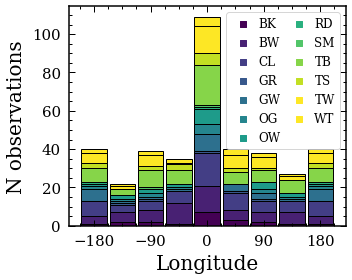

In [3]:
with matplotlib.rc_context(context):
    plt.figure(figsize=(5,4))
    colors = []
    for subtype in np.unique(df['type']):
        color = plt.cm.viridis(df['color'][df['type']==subtype].iloc[0]/11)
        colors.append(color)
        n,_ = np.histogram(df['lon'][df['type']==subtype], bins=np.arange(-180-45/2,180+45/2+1,45))
        print(subtype, n)
        plt.scatter([],[], marker='s', color=color, label=f"{subtype}")
    plt.hist([df['lon'][df['type']==subtype] for subtype in np.unique(df['type'])], 
             bins=np.arange(-180-45/2,180+45/2+1,45), stacked=True, rwidth=0.9, 
             color=colors, edgecolor='k', align='mid')
    plt.legend(ncol=2, columnspacing=0.5, handletextpad=0.3)
    plt.ylabel('N observations')
    plt.xlabel('Longitude')
    plt.xticks(np.arange(-180,181,90))
    plt.tight_layout()
    plt.savefig('obs_hist.png', format='png', bbox_to_inches='tight')
    plt.show()

<a id='Color_Magnitude_Diagram'></a>
### Color_Magnitude_Diagram

Back to [TOC](#TOC)

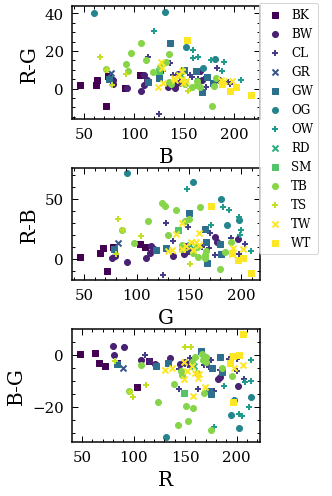

In [4]:
with matplotlib.rc_context(context):
    symbols = ['s', 'o', '+', 'x']
    fig, ax = plt.subplots(3,1, figsize=(4.5,7))
    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax[0].scatter(df['B'][(df['type']==subtype) & (df['lon']==0)],
                      df['R'][(df['type']==subtype) & (df['lon']==0)]-
                      df['G'][(df['type']==subtype) & (df['lon']==0)], 
                      color=color, marker=symbols[i%4], label=subtype)
    ax[0].set_ylabel('R-G')
    ax[0].set_xlabel('B')

    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax[1].scatter(df['G'][(df['type']==subtype) & (df['lon']==0)],
                      df['R'][(df['type']==subtype) & (df['lon']==0)]-
                      df['B'][(df['type']==subtype) & (df['lon']==0)], 
                      color=color, marker=symbols[i%4])
    ax[1].set_ylabel('R-B')
    ax[1].set_xlabel('G')

    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax[2].scatter(df['R'][(df['type']==subtype) & (df['lon']==0)], 
                      df['B'][(df['type']==subtype) & (df['lon']==0)]-
                      df['G'][(df['type']==subtype) & (df['lon']==0)], 
                      color=color, marker=symbols[i%4])
    ax[2].set_ylabel('B-G')
    ax[2].set_xlabel('R')
    plt.tight_layout()
    plt.subplots_adjust(left=0.2,right=0.78, hspace=0.43)
    fig.legend(bbox_to_anchor=[1,0.99], loc='upper right', handletextpad=0.3)
    plt.savefig('color_mag-0.png', format='png', bbox_to_inches='tight')
    plt.show()
    #color color of single category and viewing geometry

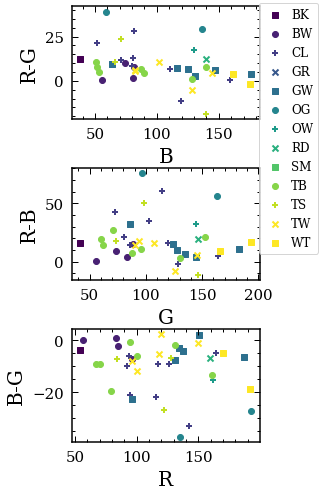

In [5]:
with matplotlib.rc_context(context):
    symbols = ['s', 'o', '+', 'x']
    fig, ax = plt.subplots(3,1, figsize=(4.5,7))
    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax[0].scatter(df['B'][(df['type']==subtype) & (df['lon']==180)],
                      df['R'][(df['type']==subtype) & (df['lon']==180)]-
                      df['G'][(df['type']==subtype) & (df['lon']==180)], 
                      color=color, marker=symbols[i%4], label=subtype)
    ax[0].set_ylabel('R-G')
    ax[0].set_xlabel('B')

    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax[1].scatter(df['G'][(df['type']==subtype) & (df['lon']==180)],
                      df['R'][(df['type']==subtype) & (df['lon']==180)]-
                      df['B'][(df['type']==subtype) & (df['lon']==180)], 
                      color=color, marker=symbols[i%4])
    ax[1].set_ylabel('R-B')
    ax[1].set_xlabel('G')

    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax[2].scatter(df['R'][(df['type']==subtype) & (df['lon']==180)], 
                      df['B'][(df['type']==subtype) & (df['lon']==180)]-
                      df['G'][(df['type']==subtype) & (df['lon']==180)], 
                      color=color, marker=symbols[i%4])
    ax[2].set_ylabel('B-G')
    ax[2].set_xlabel('R')
    plt.tight_layout()
    plt.subplots_adjust(left=0.2,right=0.78, hspace=0.43)
    fig.legend(bbox_to_anchor=[1,0.99], loc='upper right', handletextpad=0.3)
    plt.savefig('color_mag-180.png', format='png', bbox_to_inches='tight')
    plt.show()

<a id='KMeans_Test'></a>
### KMeans_Test

Back to [TOC](#TOC)

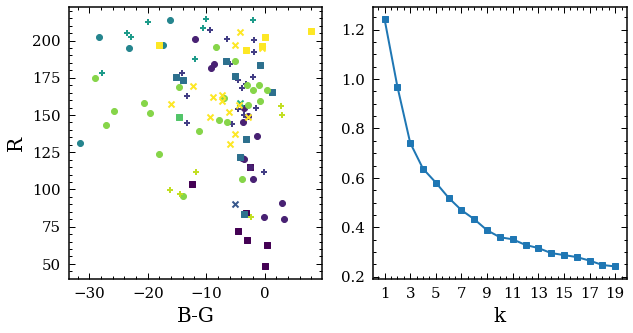

In [6]:
with matplotlib.rc_context(context):
    symbols = ['s', 'o', '+', 'x']
    fig, (ax,ax2) = plt.subplots(1,2, figsize=(10,5))
    for i,(subtype,color) in enumerate(zip(np.unique(df['type']),colors)):
        ax.scatter(df['B'][(df['type']==subtype) & (df['lon']==0)]-
                   df['G'][(df['type']==subtype) & (df['lon']==0)],
                   df['R'][(df['type']==subtype) & (df['lon']==0)], 
                   color=color, marker=symbols[i%4], label=subtype)
    ax.set_ylabel('R')
    ax.set_xlabel('B-G')
    
    scaler = StandardScaler()
    spromarr = np.array(np.column_stack([df['B'][df['lon']==0]-df['G'][df['lon']==0], df['R'][df['lon']==0]]))
    scaler.fit(spromarr)
    newdata = scaler.transform(spromarr)
    distort = []
    K = range(1,20)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(newdata)
        kmeanModel.fit(newdata)
        distort.append(sum(np.min(cdist(newdata,kmeanModel.cluster_centers_, 'euclidean'), axis=1)) 
                       / newdata.shape[0])
    ax2.plot(K, distort, marker='s')
    ax2.set_xlabel('k')
    ax2.set_xticks(np.arange(1,20,2))
    plt.show()

<a id='Silhouette_Analysis'></a>
### Silhouette_Analysis

Back to [TOC](#TOC)

For n_clusters = 2 The average silhouette_score is : 0.37720193900835663


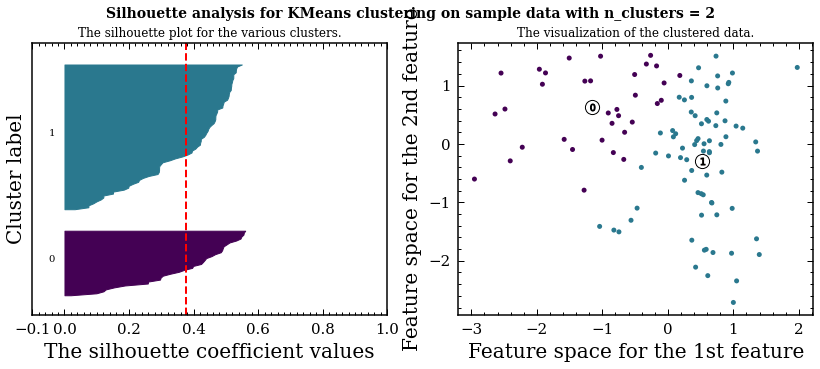

For n_clusters = 3 The average silhouette_score is : 0.4404715817069938


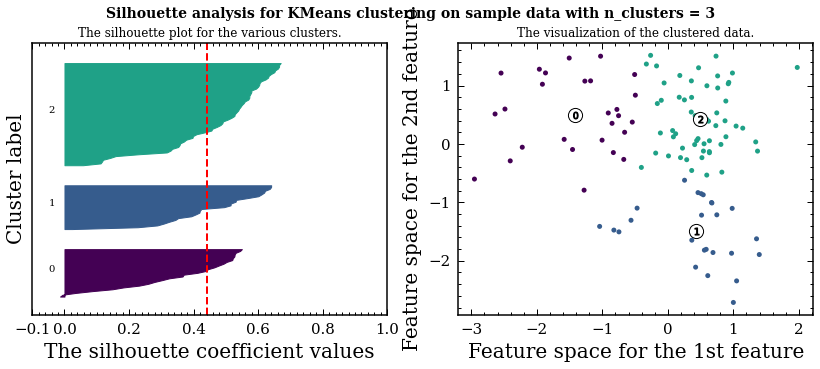

For n_clusters = 4 The average silhouette_score is : 0.3786409823735875


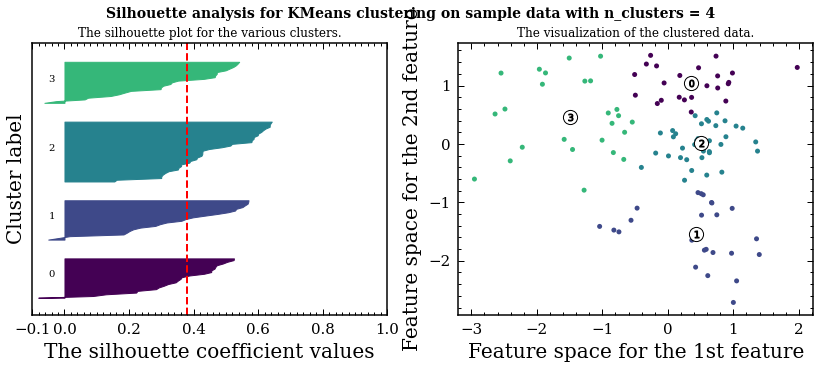

For n_clusters = 5 The average silhouette_score is : 0.3860019527771404


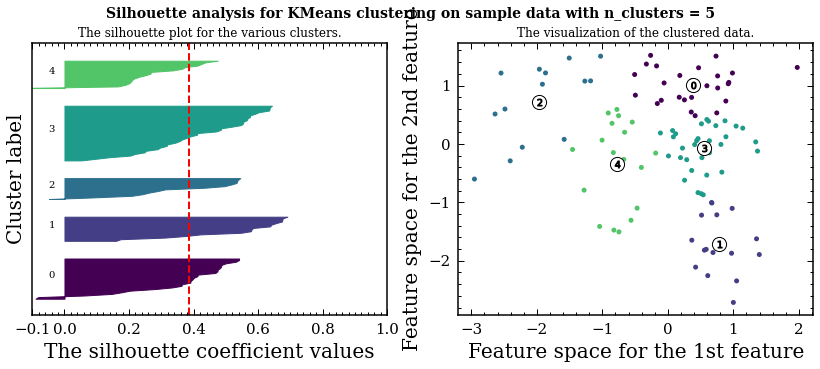

For n_clusters = 6 The average silhouette_score is : 0.3856056491632745


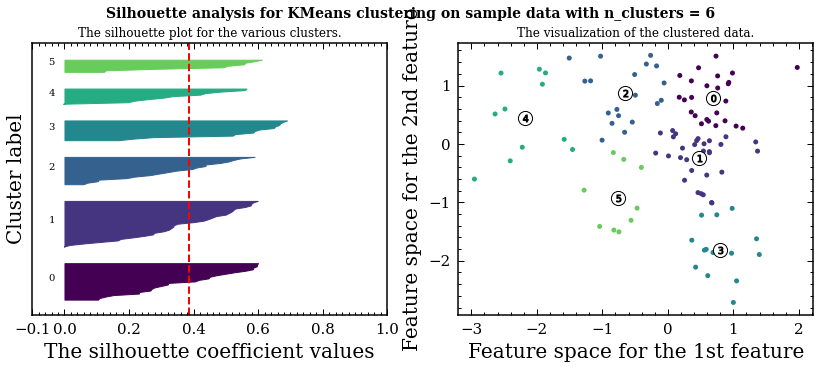

For n_clusters = 7 The average silhouette_score is : 0.38707370379709366


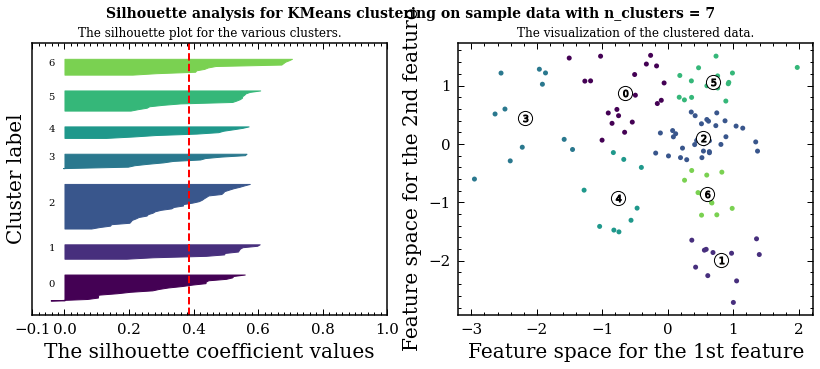

For n_clusters = 8 The average silhouette_score is : 0.4003481115704951


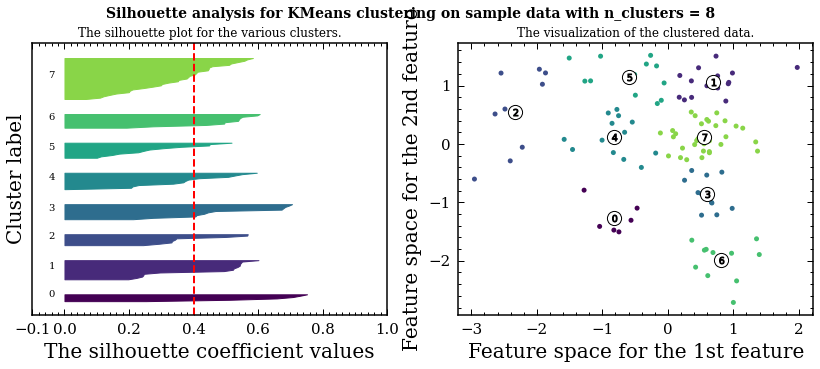

For n_clusters = 9 The average silhouette_score is : 0.42620177775060264


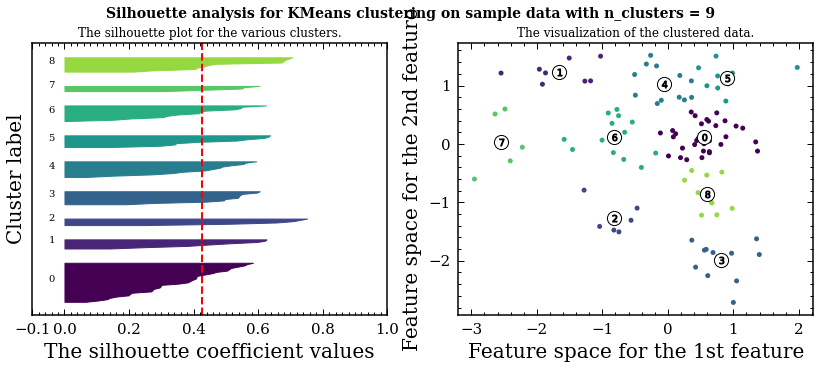

For n_clusters = 10 The average silhouette_score is : 0.4158754062442375


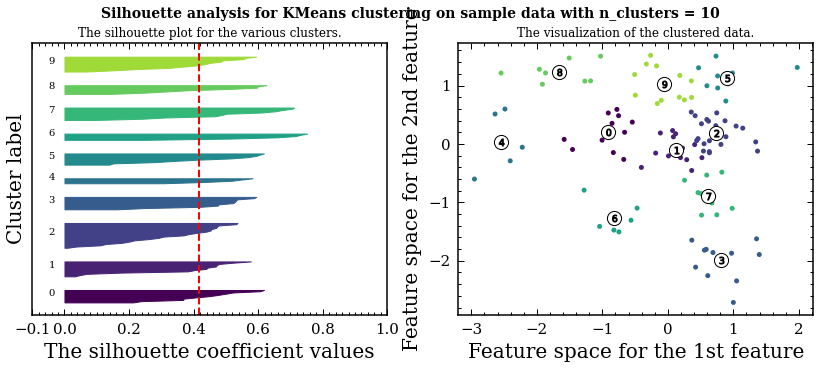

For n_clusters = 11 The average silhouette_score is : 0.4152360999394984


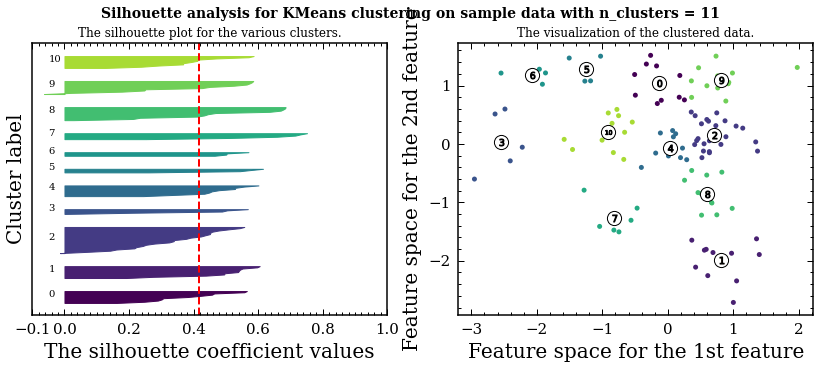

For n_clusters = 12 The average silhouette_score is : 0.4155384859321806


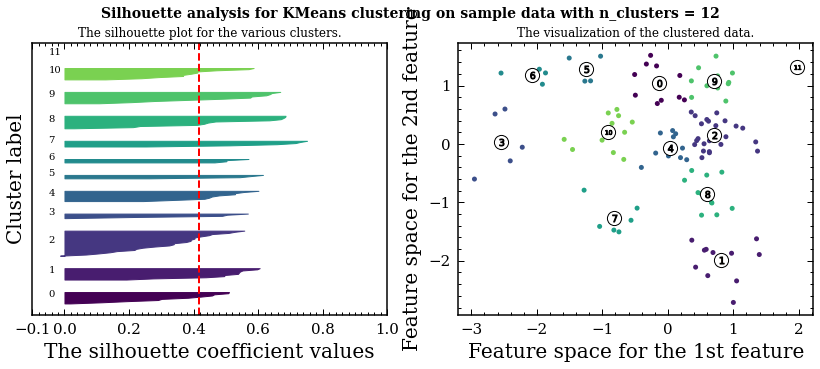

For n_clusters = 13 The average silhouette_score is : 0.4015603005255142


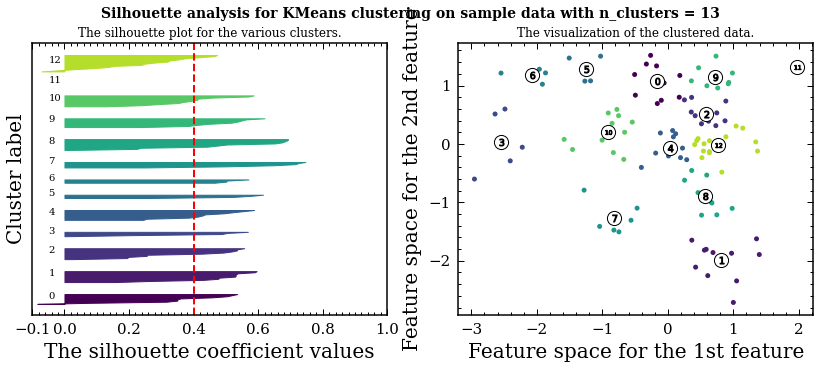

For n_clusters = 14 The average silhouette_score is : 0.38983483398799523


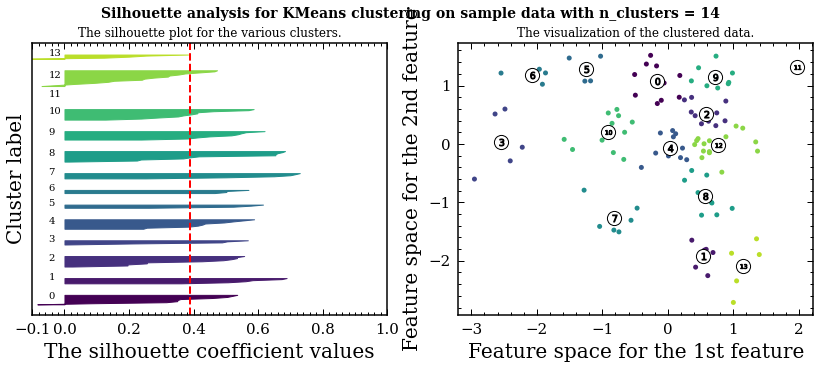

In [7]:
with matplotlib.rc_context(context):
    scaler = StandardScaler()
    scaler.fit(np.array(spromarr))
    X = scaler.transform(spromarr)
    range_n_clusters = range(2,15)
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(14, 5)
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            kcolor = plt.cm.viridis(float(i) / (n_clusters+0.5))
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=kcolor, edgecolor=kcolor)
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")
        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        # 2nd Plot showing the actual clusters formed
        kcolors = plt.cm.viridis(cluster_labels.astype(float) / (n_clusters+0.5))
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0,
                    c=kcolors, edgecolor='k')
        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')
        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
        plt.show()

<a id='White_Light_Phase_Curves'></a>
### White_Light_Phase_Curves

Back to [TOC](#TOC)

BW: 1 15 23 
CL: 1 3 4 5 7 19 23 
GR: 2 
GW: 2 10 16 
OG: 1 3 
OW: 11 
TB: 13 26 28 29 41 47 48 
TS: 3 
TW: 18 21 23 32 46 
WT: 5 6 


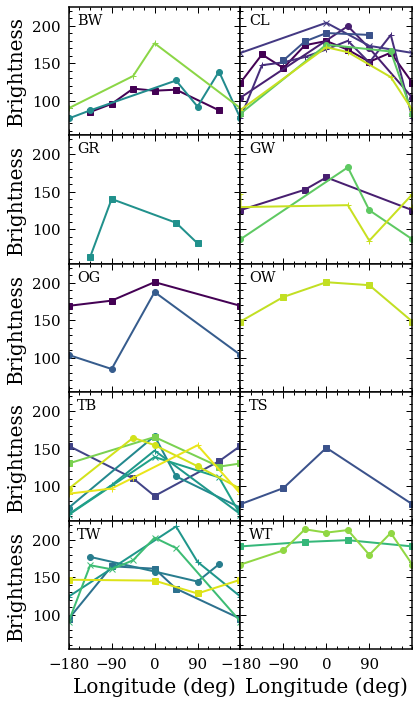

In [8]:
with matplotlib.rc_context(context):
    symbols = ['s', 'o', '+', 'x']
    types = []
    for subtype in np.unique(df['type']):
        for cat in np.unique(df['cat'][df['type']==subtype]):
            if len(df['cat'][(df['type']==subtype) & (df['cat'] == cat)]) >= 4:
                types.append(subtype)
    types = np.unique(types)
    fig, axes = plt.subplots(5,2, figsize=(6,10), sharey=True, sharex=True)
    ax = axes.flatten()
    for i,subtype in enumerate(types):
        color = plt.cm.viridis(df['color'][df['type']==subtype].iloc[0]/11)
        string = subtype + ': '
        count = 0
        for j,cat in enumerate(np.unique(df['cat'][df['type']==subtype])):
            if len(df['cat'][(df['type']==subtype) & (df['cat'] == cat)]) >= 4:
                index = df['cat'].loc[(df['type']==subtype) & (df['cat'] == cat)].index
                sortindex = np.argsort(df['lon'][index])
                avgbright = 0.299*(df['R'][index[sortindex]]) + \
                    0.587*(df['G'][index[sortindex]]) + \
                    0.114*(df['B'][index[sortindex]])
                ax[i].plot(df['lon'][index[sortindex]], avgbright, 
                               color=plt.cm.viridis(j/len(np.unique(df['cat'][df['type']==subtype]))), 
                               label=cat, marker=symbols[count % 4])
                string += f"{cat} "
                count += 1
        print(string)
        ax[i].text(0.05,0.95, subtype, transform=ax[i].transAxes, ha='left', va='top', fontsize='x-large')
        #ax[i].legend(ncol=3, title=subtype)
    for ax in axes[:,0]:
        ax.set_ylabel('Brightness')
    axes[0,0].set_xlim(-180,180)
    axes[0,0].set_xticks(np.arange(-180,180,90))
    axes[-1,0].set_xlabel('Longitude (deg)')
    axes[-1,1].set_xlabel('Longitude (deg)')
    #axes[-1,2].set_xlabel('Longitude (deg)')
    #axes[0,0].set_ylim(0,255)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('whitelight.png', format='png', bbox_to_inches='tight')
    plt.show()

<a id='Filter_Phase_Curves'></a>
### Filter_Phase_Curves

Back to [TOC](#TOC)

BW: 1 15 23 
CL: 1 3 4 5 7 19 23 
GR: 2 
GW: 2 10 16 
OG: 1 3 
OW: 11 
TB: 13 26 28 29 41 47 48 
TS: 3 
TW: 18 21 23 32 46 
WT: 5 6 


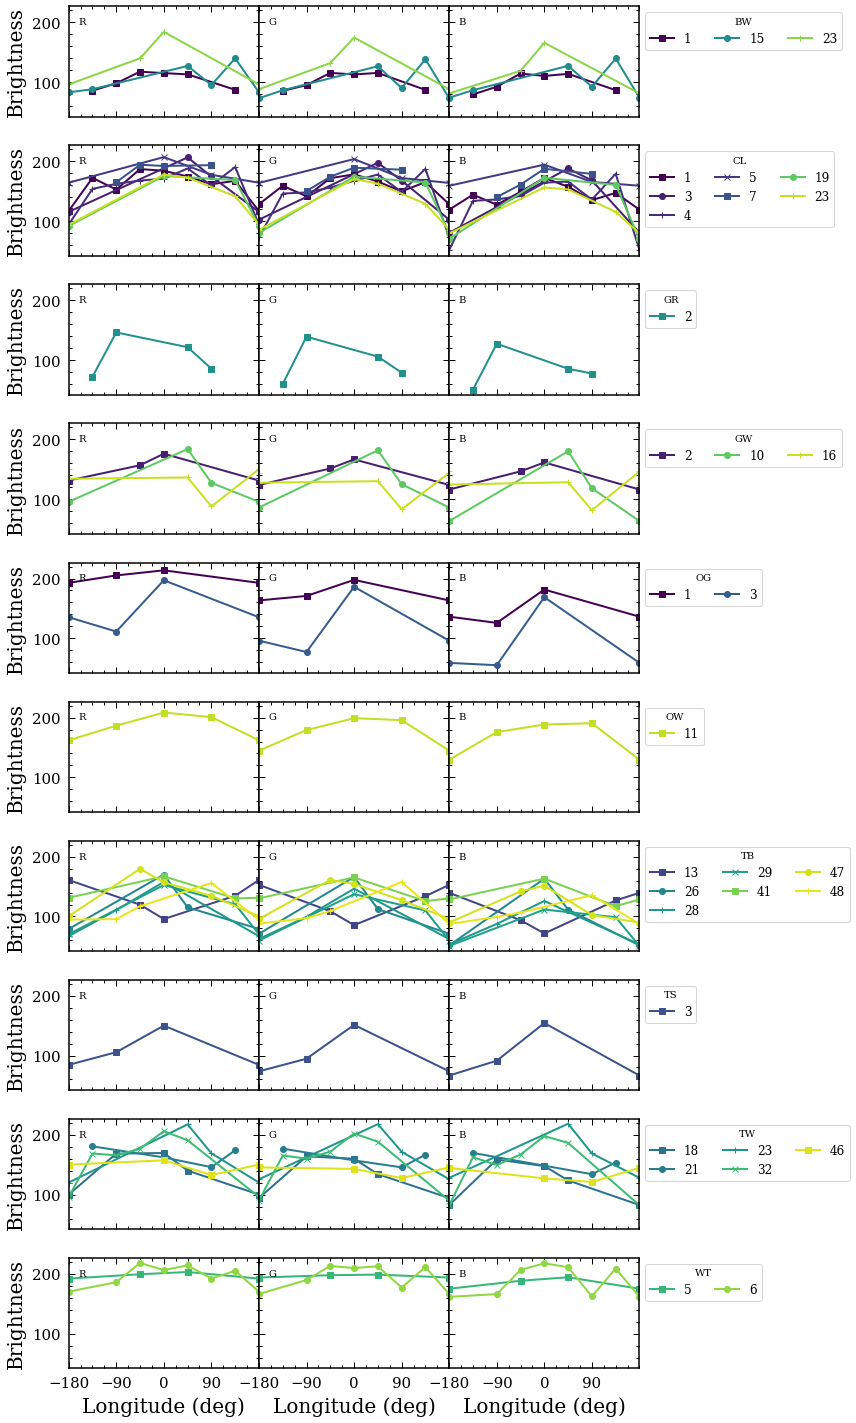

In [9]:
with matplotlib.rc_context(context):
    symbols = ['s', 'o', '+', 'x']
    types = []
    for subtype in np.unique(df['type']):
        for cat in np.unique(df['cat'][df['type']==subtype]):
            if len(df['cat'][(df['type']==subtype) & (df['cat'] == cat)]) >= 4:
                types.append(subtype)
    types = np.unique(types)
    fig, axes = plt.subplots(len(types),3, figsize=(12,len(types)*2), sharey=True, sharex=True)
    for i,subtype in enumerate(types):
        color = plt.cm.viridis(df['color'][df['type']==subtype].iloc[0]/11)
        string = subtype + ': '
        count = 0
        for j,cat in enumerate(np.unique(df['cat'][df['type']==subtype])):
            if len(df['cat'][(df['type']==subtype) & (df['cat'] == cat)]) >= 4:
                index = df['cat'].loc[(df['type']==subtype) & (df['cat'] == cat)].index
                sortindex = np.argsort(df['lon'][index])
                axes[i,0].plot(df['lon'][index[sortindex]], df['R'][index[sortindex]], 
                               color=plt.cm.viridis(j/len(np.unique(df['cat'][df['type']==subtype]))), 
                               label=cat, marker=symbols[count % 4])
                axes[i,1].plot(df['lon'][index[sortindex]], df['G'][index[sortindex]], 
                               color=plt.cm.viridis(j/len(np.unique(df['cat'][df['type']==subtype]))), 
                               label=cat, marker=symbols[count % 4])
                axes[i,2].plot(df['lon'][index[sortindex]], df['B'][index[sortindex]], 
                               color=plt.cm.viridis(j/len(np.unique(df['cat'][df['type']==subtype]))), 
                               label=cat, marker=symbols[count % 4])
                string += f"{cat} "
                count += 1
        print(string)
        axes[i,0].text(0.05,0.9, 'R', va='top', ha='left', transform=axes[i,0].transAxes)
        axes[i,1].text(0.05,0.9, 'G', va='top', ha='left', transform=axes[i,1].transAxes)
        axes[i,2].text(0.05,0.9, 'B', va='top', ha='left', transform=axes[i,2].transAxes)
        axes[i,0].set_ylabel('Brightness')
        axes[i,2].legend(bbox_to_anchor=[1,1], ncol=3, title=subtype, loc='upper left')
    axes[0,0].set_xlim(-180,180)
    axes[0,0].set_xticks(np.arange(-180,180,90))
    axes[-1,0].set_xlabel('Longitude (deg)')
    axes[-1,1].set_xlabel('Longitude (deg)')
    axes[-1,2].set_xlabel('Longitude (deg)')
    #axes[0,0].set_ylim(0,255)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0)
    plt.show()